In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# for type hinting
from typing import List

# for pearson corr coef and p values
from scipy.stats import pearsonr

# For plotting relationships
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, ArrowStyle
from matplotlib.text import Annotation

import seaborn as sns

# for non linear coefficients
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform, pdist
from sklearn.feature_selection import mutual_info_regression

Import full data set ( without intialisation/ filling stage), that is 2015 V1 data which misses first 30 minutes of tank filling.

Import formatted DF

In [2]:
# Load data from CSV
df = pd.read_excel('D:\SWaT_Datasets\SWaT_Dataset_Normal_v1.xlsx')

In [3]:
print(f"Date Range is from {df['Timestamp'].min()} to {df['Timestamp'].max()}")

Date Range is from 2015-12-22 16:30:00 to 2015-12-28 09:59:59


In [4]:
def drop_static_columns(df: pd.DataFrame) -> (pd.DataFrame, List[str]):
    """
    Find columns in the DataFrame where all values are the same (static columns).

    Parameters:
        df (DataFrame): All values from SWaT .

    Returns:
        df (DataFrame): Columns from SWaT which have more than 1 value.

    Example:
        df = pd.DataFrame({'LIT101': [1.111, 2.222, 3.333], 'P101': [1, 1, 0], 'P102': [1, 1, 1]})
        static_cols = get_static_columns(df, ['A', 'B', 'C'])
        # static_cols will be ['P102'] since all values are 1.
    """
    column_names = df.columns
    static_columns = []
    for column in column_names:
        if df[column].min() == df[column].max():
            static_columns.append(column)

    df_cleaned = df.drop(columns= static_columns)
    return df_cleaned, static_columns

In [5]:
df, dropped_columns = drop_static_columns(df)
print(dropped_columns)

['P102', 'P201', 'P202', 'P204', 'P206', 'P401', 'P403', 'P404', 'P502', 'P601', 'P603', 'Normal/Attack']


In [6]:
df.columns

Index(['Unnamed: 0', 'Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101',
       'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P203', 'P205',
       'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304',
       'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P402', 'UV401',
       'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503',
       'FIT504', 'P501', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P602'],
      dtype='object')

In [7]:
df.head()

,Unnamed: 0,Timestamp,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,...,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602
0,0,2015-12-22 16:30:00,0.0,124.3135,1,1,251.9226,8.313446,312.7916,0.0,...,0.001538,0.001409,0.001664,0.0,1,9.100231,0.0,3.3485,0.000256,1
1,1,2015-12-22 16:30:01,0.0,124.3920,1,1,251.9226,8.313446,312.7916,0.0,...,0.001538,0.001409,0.001664,0.0,1,9.100231,0.0,3.3485,0.000256,1
2,2,2015-12-22 16:30:02,0.0,124.4705,1,1,251.9226,8.313446,312.7916,0.0,...,0.001538,0.001409,0.001664,0.0,1,9.100231,0.0,3.3485,0.000256,1
3,3,2015-12-22 16:30:03,0.0,124.6668,1,1,251.9226,8.313446,312.7916,0.0,...,0.001538,0.001409,0.001664,0.0,1,9.100231,0.0,3.3485,0.000256,1
4,4,2015-12-22 16:30:04,0.0,124.5098,1,1,251.9226,8.313446,312.7916,0.0,...,0.001538,0.001409,0.001664,0.0,1,9.100231,0.0,3.3485,0.000256,1


In [8]:
# class to act as knowledge object for each component in the system
class Component:
    def __init__(self, name, list_position, correlation_dict= None, p_value_dict= None, non_lin_correlation_dict= None, non_lin_p_value_dict = None ):
        self.name = name
        # position in results list
        self.list_position = list_position

        # empty dict for results from EDA for components relationship to all other components
        self.correlation_dict = correlation_dict if correlation_dict is not None else {}
        self.p_value_dict = p_value_dict if p_value_dict is not None else {}
        self.non_lin_correlation_dict = non_lin_correlation_dict if non_lin_correlation_dict is not None else {}
        self.non_lin_p_value_dict = non_lin_p_value_dict if p_value_dict is not None else {}

    def get_correlated_components(self, source_data= 'linear', lower_threshold= 0, upper_threshold= 1):
        """
        Returns correlations, takes optional min threshold argument (default is 1 for all values).

        Parameters:
        - threshold: The minimum correlation value.

        Returns:
        - A dictionary containing component names as keys and correlation values as values.
        """
        correlated_components = {}
        if source_data == 'linear':
            for component, correlation in self.correlation_dict.items():
                if component != self.name and  lower_threshold <= abs(correlation) <= upper_threshold:
                    correlated_components[component] = correlation
            return correlated_components

        if source_data == 'non_linear':
            correlated_components = {}
            for component, correlation in self.non_lin_correlation_dict.items():
                if component != self.name and  lower_threshold <= abs(correlation) <= upper_threshold:
                    correlated_components[component] = correlation
            return correlated_components

    def get_correlated_components_p_value(self, source_data= 'linear', lower_threshold= 0, upper_threshold= 0.05):
        """
        Returns correlated components by p-value, takes optional max threshold argument (default is 1 for all values).

        Parameters:
        - threshold: The minimum correlation value.

        Returns:
        - A dictionary containing component names as keys and p values as values.
        """
        correlated_components_p_value = {}

        if source_data == 'linear':
            for component, p_value in self.p_value_dict.items():
                if component != self.name and  lower_threshold <= p_value <= upper_threshold:
                    correlated_components_p_value[component] = p_value
            return correlated_components_p_value

        if source_data == 'non_linear':
            for component, p_value in self.non_lin_p_value_dict.items():
                if component != self.name and  lower_threshold <= p_value <= upper_threshold:
                    correlated_components_p_value[component] = p_value
            return correlated_components_p_value


    def plot_network(self, source_data= 'correlation_matrix',lower_threshold= 0.5, upper_threshold= 1, layout= nx.spring_layout ):
        """
        Plot a network of components linked by correlation strength above a certain threshold.
        """
        # Create a graph
        G = nx.Graph()

        if source_data == 'correlation_matrix':
            # Add nodes (components) and edges ( correlation)
            for component, correlation in self.get_correlated_components('linear', lower_threshold,upper_threshold).items():
                G.add_node(component, correlation_strength=correlation)
                G.add_edge(self.name, component, weight= correlation)
            # Set title
            plt.title(f"Network of Components Linked by Correlation Strength (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")

        elif source_data == 'correlation_p_value':
            # Add nodes (components) and edges ( correlation)
            for component, p_value in self.get_correlated_components_p_value('linear', lower_threshold, upper_threshold).items():
                G.add_node(component, correlation_strength= p_value)
                G.add_edge(self.name, component, weight= p_value)

            # Set title
            plt.title(f"Network of Components Linked by P Value (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")

        if source_data == 'non_lin_correlation':
            # Add nodes (components) and edges ( correlation)
            for component, correlation in self.get_correlated_components('non_linear', lower_threshold,upper_threshold).items():
                G.add_node(component, correlation_strength=correlation)
                G.add_edge(self.name, component, weight= correlation)
            # Set title
            plt.title(f"Network of Components Linked by Non Linear Correlation Strength (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")

        elif source_data == 'non_lin_correlation_p_value':
            # Add nodes (components) and edges ( correlation)
            for component, p_value in self.get_correlated_components_p_value('non_linear', lower_threshold,upper_threshold).items():
                G.add_node(component, correlation_strength= p_value)
                G.add_edge(self.name, component, weight= p_value)
            # Set title
            plt.title(f"Network of Components Linked by Non Linear P Value (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")



        # Draw the graph
        pos = layout(G)  # Use layout argument if passed
        nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        # Show the plot
        plt.show()


    def plot_comparison_network(self, lower_threshold=0.5, upper_threshold=1, layout=nx.spring_layout):
        """
        Plot a network of components linked by correlation strength above a certain threshold,
        showing an edge if either linear or non-linear correlation is above the minimum threshold,
        and differentiating between correlations with curved edges. Labels are offset to reduce overlap.
        """
        G = nx.MultiDiGraph()

        # Add nodes and edges for linear correlation
        for component, correlation in self.correlation_dict.items():
            if lower_threshold <= abs(correlation) <= upper_threshold or abs(self.non_lin_correlation_dict.get(component, 0)) > lower_threshold:
                G.add_node(component, correlation_strength=correlation)
                G.add_edge(self.name, component, weight=correlation, correlation_type='Linear')

        # Add nodes and edges for non-linear correlation
        for component, correlation in self.non_lin_correlation_dict.items():
            if lower_threshold <= abs(correlation) <= upper_threshold or abs(self.correlation_dict.get(component, 0)) > lower_threshold:
                G.add_node(component, correlation_strength=correlation)
                G.add_edge(self.name, component, weight=correlation, correlation_type='Non-linear')

        plt.figure(figsize=(10, 10))
        pos = layout(G)

        # Draw nodes and labels
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", alpha=0.6)
        nx.draw_networkx_labels(G, pos, font_weight="bold")

        # Function to draw edges with FancyArrowPatch and labels with offset
        def draw_edges_with_arrows_and_labels():
            for (u, v, attribs) in G.edges(data=True):
                edge_type = attribs['correlation_type']
                weight = attribs['weight']
                color = 'red' if edge_type == 'Non-linear' else 'blue'
                style = 'dashed' if edge_type == 'Non-linear' else 'solid'
                rad = 0.1 if edge_type == 'Non-linear' else -0.1

                arrow = FancyArrowPatch(pos[u], pos[v], arrowstyle='-|>', color=color,
                                        linestyle=style, connectionstyle=f'arc3,rad={rad}', linewidth=2, alpha=0.5)
                plt.gca().add_patch(arrow)

                # Calculate label position with offset
                label_x = (pos[u][0] + pos[v][0]) / 2
                label_y = (pos[u][1] + pos[v][1]) / 2 + (0.1 if edge_type == 'Non-linear' else -0.1)

                plt.text(label_x, label_y, f'{weight:.2f}', color='black', fontsize=10,
                         ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        draw_edges_with_arrows_and_labels()

        plt.axis('off')
        plt.title("Network of Components Linked by Correlation Strength")
        plt.show()

In [9]:
def sampled_correlation(df, col_1, col_2, no_samples= 10, sample_size= 0.1):
    """
    Performs Monte Carlo Sampling to get linear and non linear correlation between 2 components.

    Parameters:
    - df: pandas.Dataframe
    - col_1: Str of first column name
    - col_2: Str of second column name
    - no_samples: number of times to repeat sampling, default is 10
    - sample_size: Proportion of dataset to take as random samples, default is 10%

    Returns:
    - Pearson and Spearman Correlation Coeficients as tupple
    """
    # lists to store result from each itteration
    pearson_corrs = []
    spearman_corrs = []

    # number of rows from dataset to sample
    rows_to_sample= int(len(df) * sample_size)

    for _ in range(no_samples):
        # Randomly sample the DataFrame
        sample_df = df.sample(n=rows_to_sample)

        # Calculate Pearson and Spearman correlations for the sampled data
        pearson_corr = sample_df[col_1].corr(sample_df[col_2], method='pearson')
        spearman_corr = sample_df[col_1].corr(sample_df[col_2], method='spearman')

        # Append the correlations to their respective lists
        pearson_corrs.append(pearson_corr)
        spearman_corrs.append(spearman_corr)

    # Calculate the mean of the correlation coefficients
    mean_pearson = np.mean(pearson_corrs)
    mean_spearman = np.mean(spearman_corrs)

    return (mean_pearson, mean_spearman)

In [10]:
#
pearson_corr, spearman_corr = sampled_correlation(df, 'LIT101', 'FIT101', 3, 0.6)
print(f'Pearson:{pearson_corr}, Spearman:{spearman_corr}')

Pearson:-0.6463209505845038, Spearman:-0.4865048645304563


In [11]:
pearson_corr, spearman_corr = sampled_correlation(df, 'LIT101', 'FIT101', 3, 0.01)
print(f'Pearson:{pearson_corr}, Spearman:{spearman_corr}')

Pearson:-0.6548191599126892, Spearman:-0.4935689065875961


In [12]:
type(LIT101_FIT101_Corr)

NameError: name 'LIT101_FIT101_Corr' is not defined

In [ ]:
# loop through sample sizes and add results to dict
def sampling_comparisson(df, col_1, col_2, no_samples= 10, min_proportion= 0.1, max_proportion= 1, step_size= 100):
    sample_sizes= np.linspace(min_proportion, max_proportion, step_size)
    results = {'Sample Size': [], 'Mean Pearson': [], 'Mean Spearman': []}

    for size in sample_sizes:
        # call function to calc values
        pearson_corr, spearman_corr= sampled_correlation(df, col_1, col_2, no_samples, size)

        # Store results
        results['Sample Size'].append(size)
        results['Mean Pearson'].append(np.mean(pearson_corr))
        results['Mean Spearman'].append(np.mean(spearman_corr))

    return results


In [17]:
correlation_list = ['FIT101', 'P101', 'MV101', 'FIT201', 'MV201', 'P203', 'AIT202']

all_results =[]
for component in correlation_list:
    results = sampling_comparisson(df, 'LIT101', component, 5, 0.001, 1, 20)
    all_results.append((component, results))


KeyboardInterrupt: 

In [45]:
# Plotting the results
def plot_correlation_results(results):
    plt.figure(figsize=(10, 6))
    plt.plot(results['Sample Size'], results['Mean Pearson'], label='Pearson')
    plt.plot(results['Sample Size'], results['Mean Spearman'], label='Spearman')

    plt.xlabel('Sample Size Proportion')
    plt.ylabel('Mean Correlation Coefficient')
    plt.title('Correlation Coefficients by Sample Size')
    plt.legend()
    plt.grid(True)

    plt.xscale('log')
    plt.show()

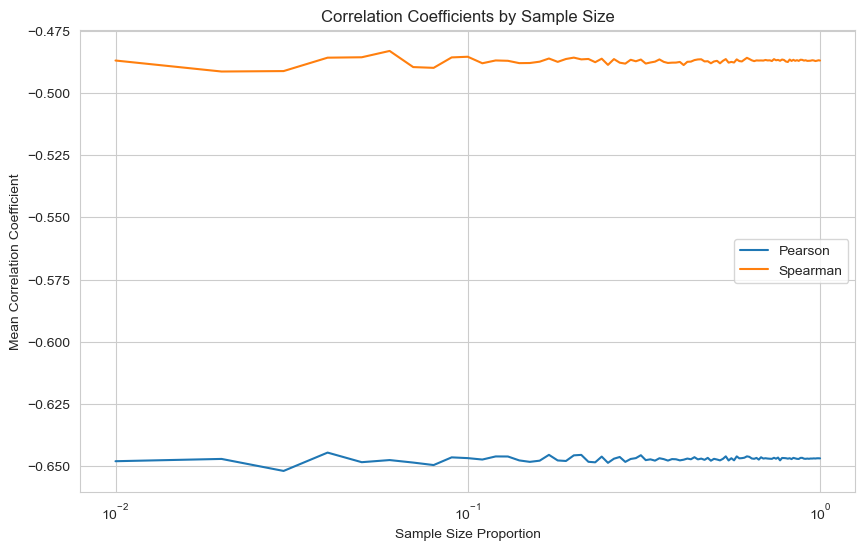

In [46]:
plot_correlation_results(results)

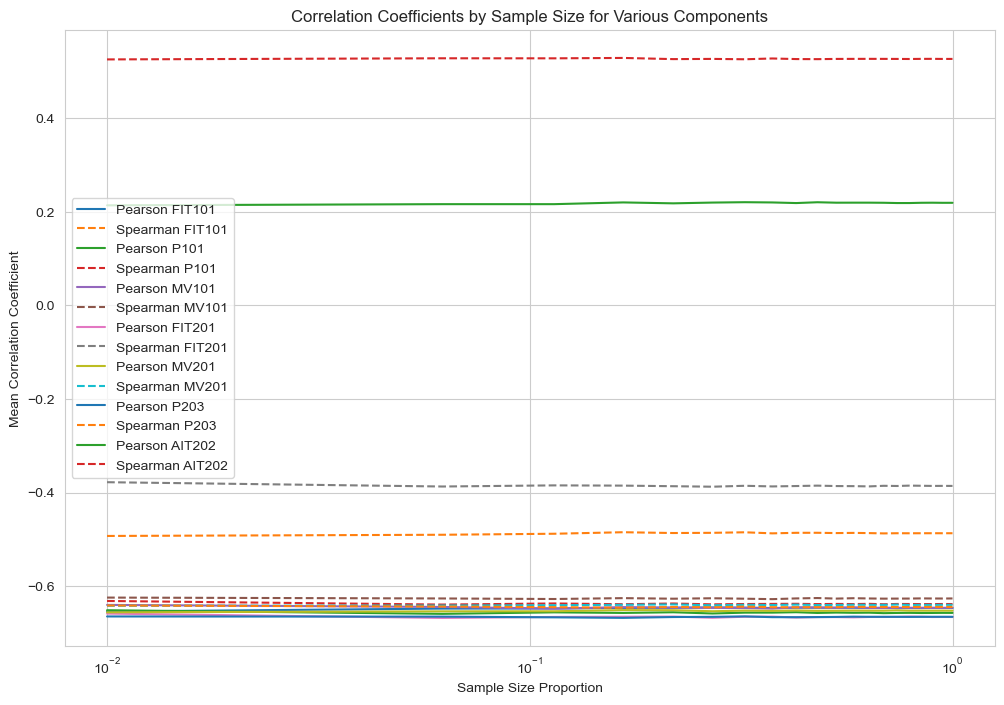

In [49]:
# Plotting
plt.figure(figsize=(12, 8))

for label, result in all_results:
    plt.plot(result['Sample Size'], result['Mean Pearson'], label=f'Pearson {label}')
    plt.plot(result['Sample Size'], result['Mean Spearman'], '--', label=f'Spearman {label}')

plt.xlabel('Sample Size Proportion')
plt.ylabel('Mean Correlation Coefficient')
plt.title('Correlation Coefficients by Sample Size for Various Components')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()

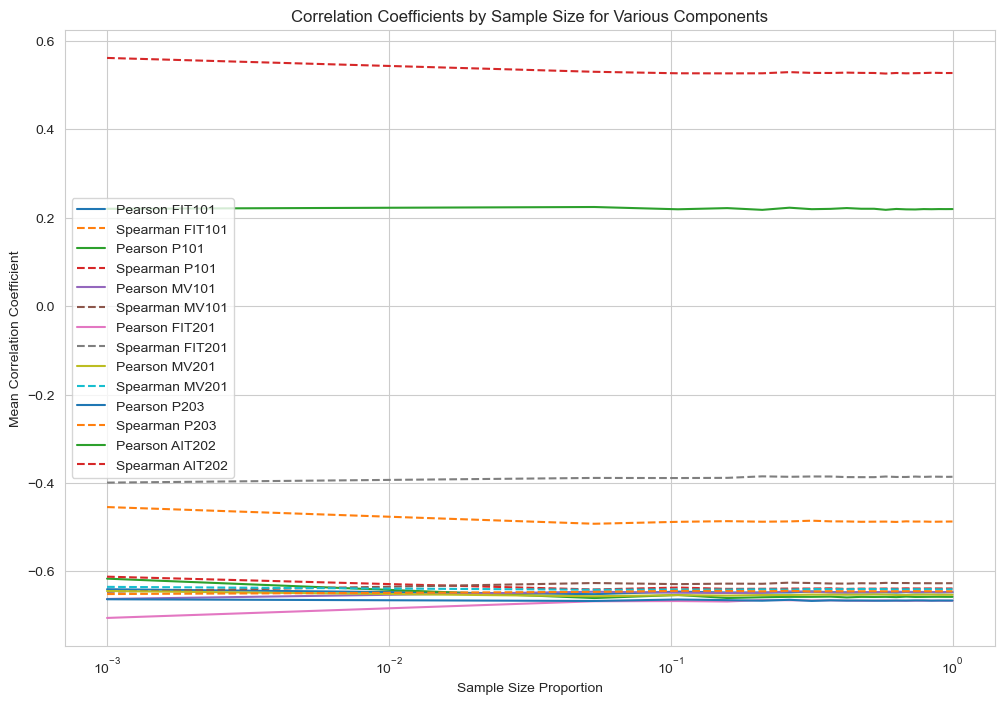

In [57]:
# Plotting
plt.figure(figsize=(12, 8))

for label, result in all_results:
    plt.plot(result['Sample Size'], result['Mean Pearson'], label=f'Pearson {label}')
    plt.plot(result['Sample Size'], result['Mean Spearman'], '--', label=f'Spearman {label}')

plt.xlabel('Sample Size Proportion')
plt.ylabel('Mean Correlation Coefficient')
plt.title('Correlation Coefficients by Sample Size for Various Components')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()

## Stagger Data to show dependencies

In [36]:
# Your chosen column and shift amount (e.g., 1 period)
chosen_column = 'LIT401'
shifts = [0,1,2,4,8,16,32,64,128,264,512]  # Positive for shifting down, negative for up

# list for correlation result tuples
shift_coefs= []

In [37]:
col_names= df.columns
cols_to_drop= ['Normal/Attack', chosen_column, 'Unnamed: 0', 'Timestamp']

cols_to_correlate = [name for name in col_names if name not in cols_to_drop]
print(cols_to_correlate)

['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'P402', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P602']


In [43]:
for shift in shifts:
    # Shifting all columns in cols_to_correlate
    df_shifted = df.copy()
    for col in cols_to_correlate:
        df_shifted[col] = df_shifted[col].shift(shift)

    all_results =[]
    for component in cols_to_correlate:
        results = sampled_correlation(df, 'LIT401', component, 1, 1)
        all_results.append((component, results))

    # save corr results for each component in tuple with shift as label
    shift_coefs.append((shift, all_results))


    #print("Original DataFrame:\n", df)
    #print("\nShifted DataFrame:\n", df_shifted)

In [44]:
shift_coefs[0]

(0,
 [('FIT101', (-0.6467889157805582, -0.48702958660562223)),
  ('LIT101', (1.0, 1.0)),
  ('MV101', (-0.6464374956467295, -0.6264600486740919)),
  ('P101', (-0.6573165546165826, -0.6384091638240074)),
  ('AIT201', (0.0043522191760236, -0.006223143837916235)),
  ('AIT202', (0.21930421449421927, 0.5268798189787125)),
  ('AIT203', (-0.13795081865954625, -0.36219590165000426)),
  ('FIT201', (-0.6660958648689131, -0.38589848410038247)),
  ('MV201', (-0.6526098237348619, -0.6401442435322324)),
  ('P203', (-0.6657199781366373, -0.6446726531933163)),
  ('P205', (-0.4882348650624795, -0.47788919990531553)),
  ('DPIT301', (-0.15280478546951767, -0.12887119016538537)),
  ('FIT301', (-0.15067407800105848, -0.07104303564098943)),
  ('LIT301', (0.18172325771437844, 0.1959392147846147)),
  ('MV301', (-0.0340244471877076, -0.04898249715713804)),
  ('MV302', (-0.14175196270895718, -0.1942573803873681)),
  ('MV303', (-0.08061340935145239, -0.11333359544305319)),
  ('MV304', (-0.011640444531558236, -0.0

In [40]:
def analyze_correlations(df_shift_coefs):
    # Initialize columns for max/min correlations, shifts, directions, and percentage change
    df_shift_coefs['Max Correlation'] = None
    df_shift_coefs['Max Shift'] = None
    df_shift_coefs['Max Direction'] = None
    df_shift_coefs['Min Correlation'] = None
    df_shift_coefs['Min Shift'] = None
    df_shift_coefs['Min Direction'] = None
    df_shift_coefs['Percentage Change'] = None

    # Iterate through each row to calculate the values
    for index, row in df_shift_coefs.iterrows():
        correlations = {col: abs(row[col]) for col in df_shift_coefs.columns if 'Corr Shift' in col}
        directions = {col: 'Positive' if row[col] >= 0 else 'Negative' for col in df_shift_coefs.columns if 'Corr Shift' in col}

        # Determine max and min correlations and their respective shifts
        max_corr_col = max(correlations, key=correlations.get)
        min_corr_col = min(correlations, key=correlations.get)

        df_shift_coefs.at[index, 'Max Correlation'] = correlations[max_corr_col]
        df_shift_coefs.at[index, 'Max Shift'] = max_corr_col.split(' ')[-1]
        df_shift_coefs.at[index, 'Max Direction'] = directions[max_corr_col]

        df_shift_coefs.at[index, 'Min Correlation'] = correlations[min_corr_col]
        df_shift_coefs.at[index, 'Min Shift'] = min_corr_col.split(' ')[-1]
        df_shift_coefs.at[index, 'Min Direction'] = directions[min_corr_col]

        # Calculate percentage change using absolute values
        if correlations[min_corr_col] != 0:
            percentage_change = ((correlations[max_corr_col] - correlations[min_corr_col]) / correlations[min_corr_col]) * 100
            df_shift_coefs.at[index, 'Percentage Change'] = percentage_change
        else:
            df_shift_coefs.at[index, 'Percentage Change'] = 'N/A'  # Or handle as appropriate

    return df_shift_coefs






In [41]:

# Assuming df_shift_coefs is your DataFrame with the structure prepared as discussed
# Call the function to perform the analysis
df_shift_coefs_min_max = analyze_correlations(df_shift_coefs)
print(df_shift_coefs_min_max)

   Component Correlation Type Direction  Corr Shift 0  Corr Shift 1  \
0     FIT101          Pearson  Negative      0.648794      0.646582   
1     FIT101         Spearman  Negative      0.487311      0.487416   
2      MV101          Pearson  Negative      0.646768      0.643394   
3      MV101         Spearman  Negative      0.627053      0.623505   
4       P101          Pearson  Negative      0.656877      0.657453   
..       ...              ...       ...           ...           ...   
73    PIT503         Spearman  Negative      0.042700      0.042537   
74    FIT601          Pearson  Negative      0.066762      0.066392   
75    FIT601         Spearman  Negative      0.045119      0.043374   
76      P602          Pearson  Negative      0.062863      0.060755   
77      P602         Spearman  Negative      0.088746      0.086726   

    Corr Shift 2  Corr Shift 4  Corr Shift 8  Corr Shift 16  Corr Shift 32  \
0       0.645244      0.644421      0.645018       0.648637       0.6

In [42]:
df_shift_coefs_min_max.to_csv("df_shift_coefs_min_max_LIT401.csv")